In [1]:
from metrics import (
    SquaredError, 
    
    FunctionClassError, 
    FCErrorQuadrants,
    FCErrorOrthogonal,
    FCErrorSeenPoints,

    RegressionScore,
)
from metrics.utils import post_process
from function_classes.wrappers import (
    ScaledXRegression,
    ScaledYRegression,
    NoisyXRegression,
    NoisyYRegression,
)

from models import (
    LeastSquaresModel,
    LassoModel,
    RetrievalDictModel,
    ZeroModel,
)

from interactive import load_checkpoint_with_config

from function_classes import (
    LinearRegression,
    SparseLinearRegression,
    DecisionTreeRegression,
    Retrieval,
)

from itertools import chain
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
import torch

In [2]:
from typing import NamedTuple
from pathlib import Path

from utils import get_latest_checkpoint_path_from_dir

class ModelLoadSpecs(NamedTuple):
    name: str
    checkpoint_dir: Path

model_load_specs: list[ModelLoadSpecs] = [ModelLoadSpecs(name='Base_Model', checkpoint_dir=Path('/home/morten/Dokumenter/incontext_playground/models/offline-20240623_183847-jzdgynak')), 
                                          ModelLoadSpecs(name='Lora_Finetune', checkpoint_dir=Path('/home/morten/Dokumenter/incontext_playground/models/offline-20240623_184001-txeoyw89'))]

MODELS = {
    load_specs.name: load_checkpoint_with_config(str(load_specs.checkpoint_dir / "config.yml"), 
                                                 str(get_latest_checkpoint_path_from_dir(load_specs.checkpoint_dir)), 
                                                 import_configs=False)
    for load_specs in model_load_specs
    # RetrievalDictModel(x_dim=X_DIM, y_dim=Y_DIM),
    # ZeroModel(x_dim=X_DIM, y_dim=Y_DIM),
    # LeastSquaresModel(x_dim=X_DIM, y_dim=Y_DIM),
    # LassoModel(alpha=0.001, x_dim=X_DIM, y_dim=Y_DIM),
}

In [3]:
METRIC = SquaredError()
NUM_BATCHES, B_SIZE, SEQ_LEN, X_DIM, Y_DIM = 1, 10, 41, 1, 1
X_SHAPE = torch.Size([B_SIZE, SEQ_LEN, X_DIM])
Y_SHAPE = torch.Size([B_SIZE, SEQ_LEN, Y_DIM])

x_dist = MultivariateNormal(torch.zeros(X_SHAPE), torch.eye(X_DIM)) #batch size, sequence_length, x_dim

base_fc = LinearRegression(x_dist, y_dim=Y_DIM)

bench = FunctionClassError(METRIC, function_class=base_fc)

In [4]:
errs = bench.evaluate(MODELS.values(), num_batches=100)
values = list(post_process(errs))

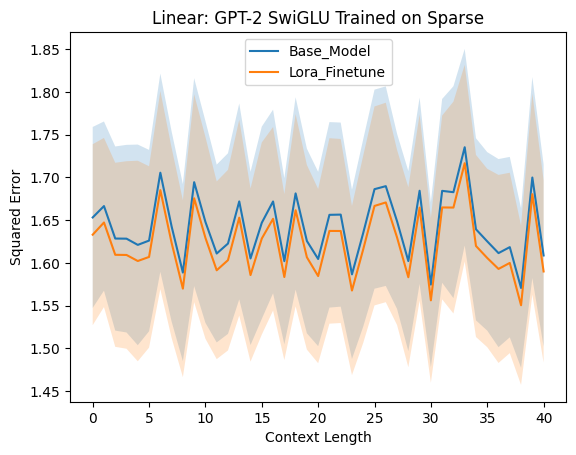

In [5]:
for name, results in zip(MODELS.keys(), values):
    plt.plot("accuracy", data=results, label=f"{name}")
    plt.fill_between(range(41), results["confidence_0.01_lower"][:, 0], results["confidence_0.01_upper"][:, 0], alpha=0.2)

plt.ylabel(f"Squared Error")
plt.xlabel(f"Context Length")
# plt.title(f"Linear: GPT-2 RMS SwiGLU Trained on Sparse")
plt.title(f"Linear: GPT-2 SwiGLU Trained on Sparse")
# plt.title(f"Sparse Linear: GPT-2 RMS over training")
# plt.title(f"Sparse Linear: GPT-2 SwiGLU over training")
# plt.title(f"Decision Tree: Mamba over training")
# plt.title(f"Decision Tree: GPT-2 RMS over training")
# plt.legend(bbox_to_anchor=(1., 0.75))
plt.legend()
plt.show()